# House Detector

In [49]:
# !pip install tensorflow
!pip install -U -q PyDrive
!pip install "tensorflow_hub>=0.6.0"

import tensorflow as tf
tf.__version__


!rm -rf ./data
!rm -rf ./*

In [50]:
!wget https://github.com/thejawker/architector/raw/master/data/house_vs_no_house.zip -P /content/data

--2020-04-24 02:03:18--  https://github.com/thejawker/architector/raw/master/data/house_vs_no_house.zip
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thejawker/architector/master/data/house_vs_no_house.zip [following]
--2020-04-24 02:03:18--  https://raw.githubusercontent.com/thejawker/architector/master/data/house_vs_no_house.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41373417 (39M) [application/zip]
Saving to: ‘/content/data/house_vs_no_house.zip’

house_vs_no_house.z 100%[===================>]  39.46M   146MB/s    in 0.3s    

2020-04-24 02:03:19 (146 MB/s) - ‘/content/data/house_vs_no_

In [51]:
# Get files ready
from os import getcwd
import os
import zipfile
from shutil import copyfile

data_dir = f"{getcwd()}/data"
tmp_dir = f"{data_dir}/tmp"
houses_dir = f"{data_dir}/house_vs_no_house.zip"


# delete tmp
!rm -rf ./data/tmp

print(houses_dir)
with zipfile.ZipFile(houses_dir, 'r') as zip_obj:
  zip_obj.extractall(f"{tmp_dir}/raw/")

/content/data/house_vs_no_house.zip


In [52]:
try:
    dirs_to_make = [
        'training/house',
        'training/no_house',
        'testing/house',
        'testing/no_house',
    ]
    
    for dir in dirs_to_make:
        os.makedirs(os.path.join(tmp_dir, dir))
except OSError:
    pass


limit = 1100
split = .9

for type in ['house', 'no_house']:
    img_dir = f"{tmp_dir}/raw/house_vs_no_house"
    data = os.listdir(os.path.join(img_dir, type))
    data = data[:limit]
    print(f'{type} contains: {len(data)} images')
    split_at = int(len(data) * split)
    data_set = {
        'training': data[:split_at],
        'testing': data[split_at:]
    }
    
    for (dir_name, photos) in data_set.items():
        for photo in photos:            
            try:
                source = f"{img_dir}/{type}/{photo}"
                dest = f"{tmp_dir}/{dir_name}/{type}/{photo}"
                copyfile(source, dest)
            except:
                print('cant copy')
                pass

house contains: 1100 images
no_house contains: 1100 images


In [53]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

model = tf.keras.models.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/inaturalist/inception_v3/feature_vector/4",
               trainable=False, arguments=dict(batch_norm_momentum=0.997)),
    tf.keras.layers.Dense(2, activation='softmax'),
])

model.build([None, 299, 299, 3])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   multiple                  21802784  
_________________________________________________________________
dense_5 (Dense)              multiple                  4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 25

TRAINING_DIR = f"{tmp_dir}/training"
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR, 
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    target_size=(299, 299))

VALIDATION_DIR = f"{tmp_dir}/testing"
validation_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=batch_size,
                                                              class_mode='categorical', 
                                                              target_size=(299, 299))

Found 1906 images belonging to 2 classes.
Found 212 images belonging to 2 classes.


In [55]:
STEP_SIZE_TRAIN = (train_generator.n//train_generator.batch_size)
STEP_SIZE_VALID = (validation_generator.n//validation_generator.batch_size)

min_val = 0.95

class StopOnComplete(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if(logs.get('acc') > min_val):
            print(f"Reached {min_val}% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = [StopOnComplete()]

history = model.fit(train_generator,
                    epochs=60,
                    verbose=1,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_steps=STEP_SIZE_VALID,
                    validation_data=validation_generator,
                    shuffle=True,
                    callbacks=callbacks)


Epoch 1/60
76/76 [==============================] - 37s 493ms/step - loss: 0.3035 - acc: 0.8879 - val_loss: 0.3079 - val_acc: 0.9050
Epoch 2/60
76/76 [==============================] - 37s 484ms/step - loss: 0.2138 - acc: 0.9298 - val_loss: 0.3010 - val_acc: 0.9200
Epoch 3/60
76/76 [==============================] - 36s 479ms/step - loss: 0.1885 - acc: 0.9389 - val_loss: 0.2915 - val_acc: 0.9300
Epoch 4/60
76/76 [==============================] - 36s 478ms/step - loss: 0.2009 - acc: 0.9304 - val_loss: 0.2792 - val_acc: 0.9250
Epoch 5/60
76/76 [==============================] - 36s 479ms/step - loss: 0.1975 - acc: 0.9474 - val_loss: 0.2633 - val_acc: 0.9300
Epoch 6/60
76/76 [==============================] - 36s 477ms/step - loss: 0.1800 - acc: 0.9447 - val_loss: 0.2986 - val_acc: 0.9100
Epoch 7/60
76/76 [==============================] - 37s 481ms/step - loss: 0.1877 - acc: 0.9362 - val_loss: 0.3025 - val_acc: 0.9050
Epoch 8/60
76/76 [==============================] - 36s 478ms/step - 

Text(0.5, 1.0, 'Training and validation loss')

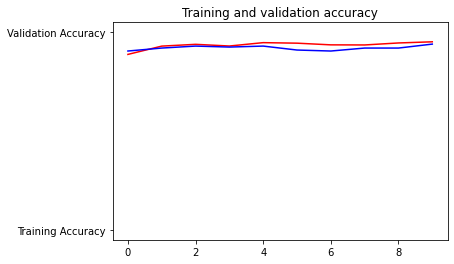

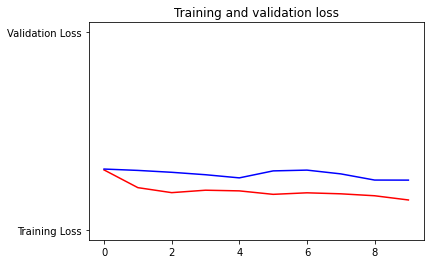

In [56]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [57]:
from keras.preprocessing import image
import numpy as np
from google.colab import files

uploaded = files.upload()

for name in uploaded.keys():
  # print(image_location)
    # if '.DS_Store' in image_location:
    #     continue
    path = os.path.join(getcwd(), name)
        
    # path = f'{data_dir}/testers/{image_location}'
    img = image.load_img(path, target_size=(299, 299))

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0) / 255
    images = np.vstack([x])

    classes = model.predict(images, batch_size=30)

    print(classes[0])

    if classes[0][0]>.9:
        print(f"{name} is a house")
    else:
        print(f"{name} is NOT a house")

Saving beach.jpg to beach.jpg
Saving cat_grass.jpg to cat_grass.jpg
Saving cat.jpeg to cat.jpeg
Saving computer.jpg to computer.jpg
Saving cool_house.jpeg to cool_house.jpeg
Saving drawing_house.jpg to drawing_house.jpg
Saving empty-box-in-a-field-of-grass-AC66D6.jpg to empty-box-in-a-field-of-grass-AC66D6.jpg
Saving green-color-interior-design-980x653.jpg to green-color-interior-design-980x653.jpg
Saving horse.jpg to horse.jpg
Saving house1.jpg to house1.jpg
Saving interior_design.jpeg to interior_design.jpeg
[0.97895575 0.02104424]
beach.jpg is a house
[0.1992936  0.80070645]
cat_grass.jpg is NOT a house
[0.04684306 0.9531569 ]
cat.jpeg is NOT a house
[0.00786489 0.99213505]
computer.jpg is NOT a house
[0.92477477 0.0752252 ]
cool_house.jpeg is a house
[0.19763549 0.8023645 ]
drawing_house.jpg is NOT a house
[0.8827305  0.11726952]
empty-box-in-a-field-of-grass-AC66D6.jpg is NOT a house
[0.24896325 0.75103676]
green-color-interior-design-980x653.jpg is NOT a house
[0.34534833 0.65465

In [60]:
# model.save('path_to_my_model.mod')
!zip path_to_my_model.mod

	zip warning: missing end signature--probably not a zip file (did you
	zip warning: remember to use binary mode when you transferred it?)
	zip warning: (if you are trying to read a damaged archive try -F)

zip error: Zip file structure invalid (path_to_my_model.mod)
